In [217]:
from qiskit import *
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit_aer import QasmSimulator
from math import gcd, floor, log
from fractions import Fraction
import numpy as np


In [218]:
def mod_mult_gate(a, N):
    if gcd(a, N) != 1:
        raise ValueError(f"gcd({a}, {N}) ≠ 1")

    n = int(np.ceil(np.log2(N)))
    dim = 2**n
    U = np.zeros((dim, dim))

    for x in range(dim):
        if x < N:
            U[a * x % N, x] = 1
        else:
            U[x, x] = 1

    U_gate = UnitaryGate(U, label=f"U_{a}")
    return U_gate


In [219]:
pow(3, 2, 4)

1

In [220]:
def period_finding_circuit(a, N):
    if gcd(a, N) != 1:
        raise ValueError(f"gcd({a}, {N}) ≠ 1")

    n = int(np.ceil(np.log2(N)))
    m = 2 * n  # often works well

    qc = QuantumCircuit(m + n, m)
    qc.h(range(m))  # Apply Hadamards to top register
    qc.x(m + n -1)  # Initialize bottom register to |0000...01⟩

    for i in range(m):
        power = pow(a, 2**i, N)
        control_qubit = m - 1 - i
        controlled_U = mod_mult_gate(power, N).control()
        qc.compose(controlled_U, qubits=[control_qubit] + list(range(m, m + n)), inplace=True)


    # qc.append(QFT(m, do_swaps=False).inverse(), range(m))
    qc.append(QFT(m, do_swaps=False), range(m))

    qc.barrier()
    qc.measure(range(m), range(m))

    return qc


In [221]:
def run_QPF(a, N):
    if gcd(a, N) != 1:
        raise ValueError(f"gcd({a}, {N}) ≠ 1")

    qc = period_finding_circuit(a, N)
    backend = QasmSimulator()
    transpiled_circuit = transpile(qc, backend)
    result = backend.run(transpiled_circuit.reverse_bits()).result() # run once
    counts = result.get_counts()
    measured = max(counts, key=counts.get)  # most likely result

    y = int(measured, 2)
    return y


In [222]:
def closest_fraction(y, K, N):
    return Fraction(y, K).limit_denominator(N).denominator


In [223]:
def find_order(a, N, max_attempts=100):
    if gcd(a, N) != 1:
        raise ValueError(f"gcd({a}, {N}) ≠ 1")

    n = int(np.ceil(np.log2(N)))
    m = 2 * n
    K = 2**m

    attempts = 0
    while attempts < max_attempts:
        attempts += 1
        y = run_QPF(a, N)
        r_candidate = closest_fraction(y, K, N)

        if r_candidate == 0:
            continue  # skip invalid values

        # print(f"  QPF suggested r = {r_candidate}")

        for k in range(1, N):
            r = k * r_candidate
            if pow(a, r, N) == 1:
                return r, attempts

    raise RuntimeError("Failed to find order within max_attempts")


In [224]:
if __name__ == "__main__":
    a = 8
    N = 11
    qc = period_finding_circuit(a, N)

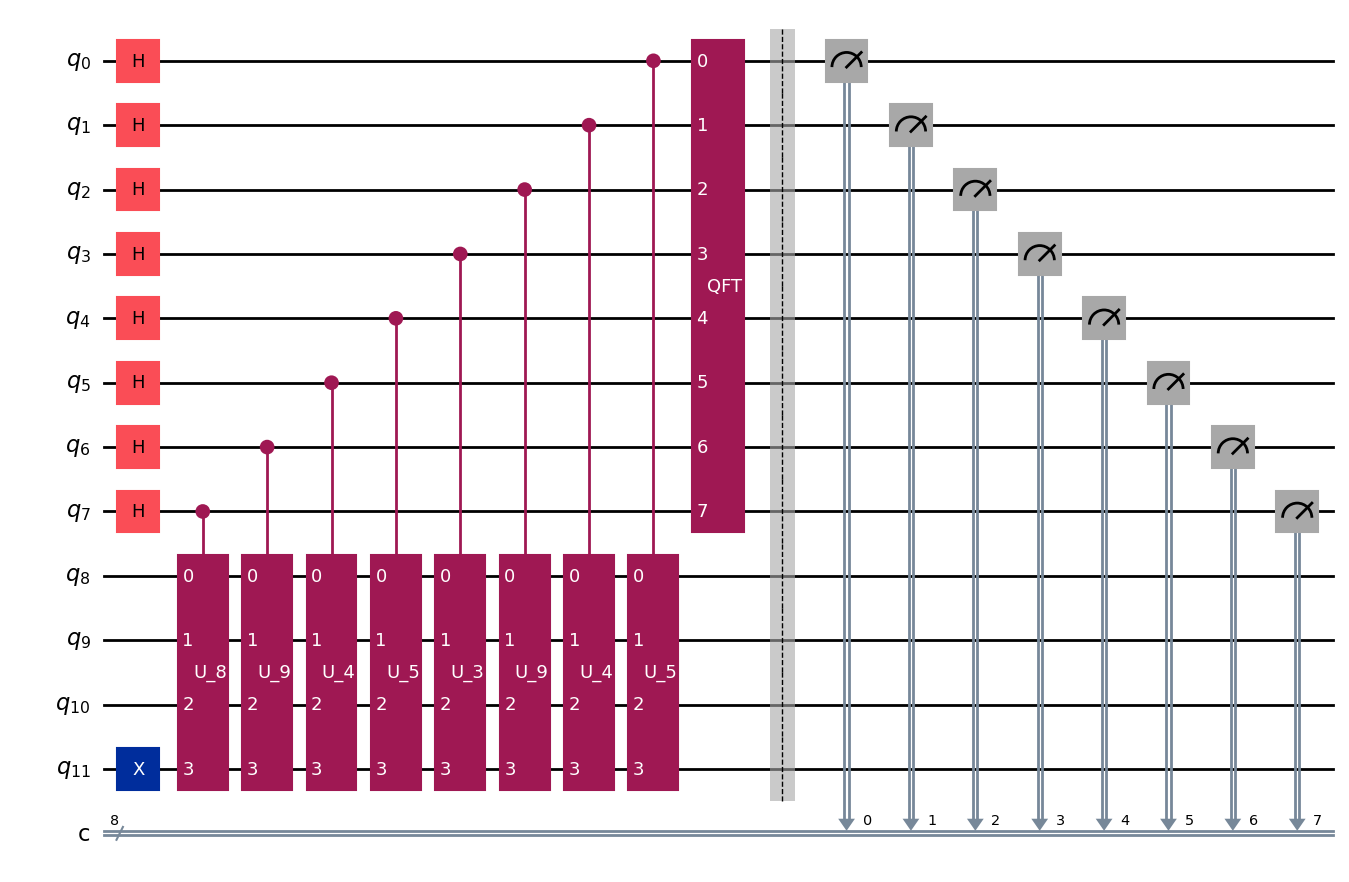

In [225]:
qc.draw('mpl')

In [226]:
if __name__ == "__main__":
    r, loops = find_order(a, N)
    print(f"Order of {a} mod {N} is {r}, found in {loops + 1} iteration(s).")


Order of 8 mod 11 is 10, found in 2 iteration(s).
